In [49]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import librosa
import librosa.display
import torch
import torch.nn as nn
import torchaudio
from torchlibrosa.stft import Spectrogram, LogmelFilterBank, STFT

/home/yuigahama/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [50]:
class F2M(nn.Module):
    """This turns a normal STFT into a MEL Frequency STFT, using a conversion
       matrix.  This uses triangular filter banks.
    Args:
        n_mels (int): number of MEL bins
        sr (int): sample rate of audio signal
        f_max (float, optional): maximum frequency. default: sr // 2
        f_min (float): minimum frequency. default: 0
    """
    def __init__(self, n_mels=40, sr=16000, f_max=None, f_min=0., n_fft=40, onesided=True):
        super().__init__()
        self.n_mels = n_mels
        self.sr = sr
        self.f_max = f_max if f_max is not None else sr // 2
        self.f_min = f_min
        self.n_fft = n_fft
        if onesided:
            self.n_fft = self.n_fft // 2 + 1
        self._init_buffers()

    def _init_buffers(self):
        m_min = 0. if self.f_min == 0 else 2595 * np.log10(1. + (self.f_min / 700))
        m_max = 2595 * np.log10(1. + (self.f_max / 700))

        m_pts = torch.linspace(m_min, m_max, self.n_mels + 2)
        f_pts = (700 * (10**(m_pts / 2595) - 1))

        bins = torch.floor(((self.n_fft - 1) * 2) * f_pts / self.sr).long()

        fb = torch.zeros(self.n_fft, self.n_mels)
        for m in range(1, self.n_mels + 1):
            f_m_minus = bins[m - 1].item()
            f_m = bins[m].item()
            f_m_plus = bins[m + 1].item()

            if f_m_minus != f_m:
                fb[f_m_minus:f_m, m - 1] = (torch.arange(f_m_minus, f_m) - f_m_minus) / (f_m - f_m_minus)
            if f_m != f_m_plus:
                fb[f_m:f_m_plus, m - 1] = (f_m_plus - torch.arange(f_m, f_m_plus)) / (f_m_plus - f_m)
        self.register_buffer("fb", fb)

    def forward(self, spec_f):
        spec_m = torch.matmul(spec_f, self.fb)  # (c, l, n_fft) dot (n_fft, n_mels) -> (c, l, n_mels)
        return spec_m


In [51]:
# Spectrogram parameters
sample_rate = 16000
n_fft = 1024
hop_length = 250
win_length = 1024
window = 'hann'
center = True
dtype = np.complex64
pad_mode = 'reflect'
data_length = 32000
# Mel parameters
n_mels = 128
fmin = 50
fmax = 7000
ref = 1.0
amin = 1e-10
top_db = None

In [52]:
y, sr = librosa.load('../../data/train/0151b7d20.flac', sr=None)
pt_data = torch.Tensor(y).unsqueeze(0)
melspectrogram_parameters = {
    'n_mels': 128,
    'fmin': 20,
    'fmax': 16000,
}

pcen_parameters = {
    'hop_length': hop_length,
    'gain': 0.98,
    'bias': 2,
    'power': 0.5,
    'time_constant': 0.4,
    'eps': 0.000001,
}

melspec = librosa.feature.melspectrogram(y, sr=sr, **melspectrogram_parameters)
pcen_ = librosa.pcen(melspec, sr=sr, **pcen_parameters)
melspec.shape

(128, 5626)

In [66]:
sp = Spectrogram(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=center,
    pad_mode=pad_mode
)

lfb = LogmelFilterBank(
    **{
    'sr': sr,
    'n_fft': 1024,
    'n_mels': 128,
    'fmin': 50,
    'fmax': 20000,
    'ref' : 1.0,
    'amin': 1e-10,
    'top_db': None,
    'is_log': False,
    'freeze_parameters': True
}
)

In [67]:
def pcen(S, sr=22050, hop_length=512, gain=0.98, bias=2, power=0.5,
         time_constant=0.400, eps=1e-6, b=None, max_size=1, ref=None,
         axis=-1, max_axis=None):
    if b is None:
        t_frames = time_constant * sr / float(hop_length)
        b = (np.sqrt(1 + 4 * t_frames**2) - 1) / (2 * t_frames**2)
    
    
    if ref is None:
        if max_size == 1:
            ref = S
        elif S.ndim == 1:
            raise ParameterError('Max-filtering cannot be applied to 1-dimensional input')
        else:
            if max_axis is None:
                if S.ndim != 2:
                    raise ParameterError('Max-filtering a {:d}-dimensional spectrogram '
                                         'requires you to specify max_axis'.format(S.ndim))
                # if axis = 0, max_axis=1
                # if axis = +- 1, max_axis = 0
                max_axis = np.mod(1 - axis, 2)

            ref = scipy.ndimage.maximum_filter1d(S, max_size, axis=max_axis)

    S_smooth = scipy.signal.lfilter([b], [1, b - 1], ref, axis=axis)
    print(S_smooth)

    # Working in log-space gives us some stability, and a slight speedup
    smooth = np.exp(-gain * (np.log(eps) + np.log1p(S_smooth / eps)))
    return (S * smooth + bias)**power - bias**power

pc = pcen(melspec, sr=sr, **pcen_parameters)
melspec_ = librosa.power_to_db(melspec)

[[2.25205298e-04 1.52474458e-03 2.11888284e-03 ... 2.69068907e-01
  2.68144720e-01 2.65536854e-01]
 [5.97849854e-04 1.90791057e-03 3.50727873e-03 ... 2.07653962e-01
  2.06535220e-01 2.04292504e-01]
 [2.82135547e-04 7.45702733e-04 1.17143599e-03 ... 5.01863429e-02
  4.99050932e-02 4.99373932e-02]
 ...
 [2.56645562e-05 4.96510127e-05 7.37232186e-05 ... 1.94312943e-02
  1.94878421e-02 1.98071298e-02]
 [2.11594594e-05 4.82860884e-05 9.62840120e-05 ... 2.32440012e-02
  2.33347754e-02 2.34821636e-02]
 [2.24548545e-05 4.94000250e-05 8.98923204e-05 ... 2.05772339e-02
  2.06137911e-02 2.07752403e-02]]


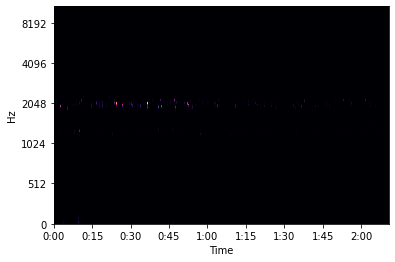

In [55]:
librosa.display.specshow(melspec, x_axis='time', y_axis='mel')

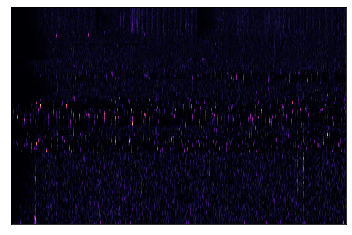

In [56]:
librosa.display.specshow(pcen_)

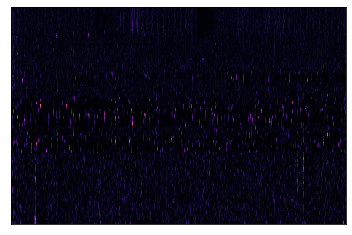

In [57]:
librosa.display.specshow(pc)

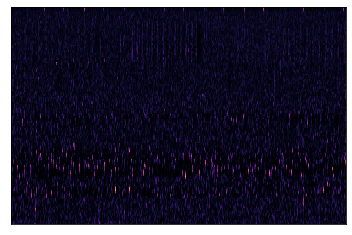

In [58]:
librosa.display.specshow(pct_.numpy())

In [70]:
class pcen_(nn.Module):
    def __init__(self, sr=22050, hop_length=512, gain=0.98, bias=2, power=0.5,time_constant=0.400, eps=1e-6, b=None, ref=None):
        super(pcen_, self).__init__()
        if b is None:
            t_frames = time_constant * sr / float(hop_length)
            self.b = (np.sqrt(1 + 4 * t_frames**2) - 1) / (2 * t_frames**2)

        self.axis = -1
        self.gain = gain
        self.bias = bias
        self.power = power
        self.eps = eps
        self.max_axis = np.mod(0, 2)
        cuda0 = torch.device('cuda:0')
        
        self.filter_a = torch.nn.Parameter(torch.tensor([1, self.b - 1], dtype=torch.float, device='cpu'), requires_grad=False)
        self.filter_b = torch.nn.Parameter(torch.tensor([self.b, 0], dtype=torch.float, device='cpu'), requires_grad=False)

        
    def forward(self, S):
        with torch.no_grad():
            S_smooth = torchaudio.functional.lfilter(S, self.filter_a, self.filter_b)
            #S_smooth = torch.tensor(sp.signal.lfilter([self.b], [1, self.b - 1], S, axis=self.axis))
            smooth = torch.exp(
                -self.gain * (np.log(self.eps) + torch.log1p(S_smooth / self.eps))
            )

            return (S * smooth + self.bias)**self.power - self.bias**self.power


pct = pcen_(sr=sr, **pcen_parameters)
pct_ = pct(lfb(sp(pt_data)))

-13.815510557964274


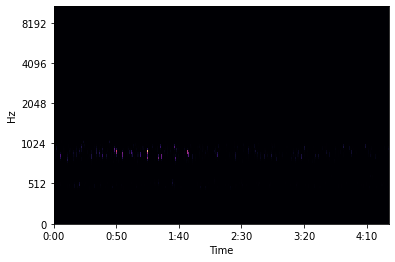

In [18]:
librosa.display.specshow(lfb(sp(pt_data)).squeeze().numpy().T, x_axis='time', y_axis='mel')

In [63]:
lfb(sp(pt_data)).size()

torch.Size([1, 1, 11521, 128])